# Figure 15: 

Similar to Fig. 10 but for tendencies calculated from the REF simulation and simulations with CRH disable at (a) day 3, (b), day 4, (c) day 5, and (d) day 6.

---
@ Behrooz Keshtgar, KIT 2022

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker
import xarray as xr
import colorlegend
from matplotlib import ticker

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.19.1
matplotlib: 3.3.0


## 2- Loading derived dataset from part 02

In [3]:
# loading datasets

# simulations
res = ['02_03','02_05','02_06','02_07','02_08']
#-------------------------------------
def load_simulations():
    ds_list = []
    for sim in list(res): 
        print('Working on loading data for', sim)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/pverrorgrowth/'
   
        # model output 'pv_icon' used for calculation
        fname1 = path+'pverror_diag_1x1_'+sim+'.nc'
        ds_var1 = xr.open_dataset(fname1)
        ds_var1.attrs['res'] = sim
        ds_list.append(ds_var1)
                  
    return ds_list
#----------------------------------
ds_list = load_simulations()

Working on loading data for 02_03
Working on loading data for 02_05
Working on loading data for 02_06
Working on loading data for 02_07
Working on loading data for 02_08


## 3- Helper functions

In [4]:
# functions

# gradient (center difference)
def grad(var,delta,ax):
    
    df = np.gradient(var,delta,axis=ax)
    
    return(df)

# forward difference
def obs_fd(ds):
    if ds.attrs['res'] == 'native':
        obs_fd = np.zeros((ds.time.size,ds.ncells.size)) * np.nan
    else:
        obs_fd = np.zeros((ds.time.size,ds.lev.size,ds.lat.size,ds.lon.size)) * np.nan
    for t in range(len(ds.time)-1):
        obs_fd[t] = (ds.dpe[t+1] - ds.dpe[t])/3600 
        
    obs_fd[-1] =  (ds.dpe[-1] - ds.dpe[-2])/3600 
    
    if ds.attrs['res'] == 'native':
        obs_fd_da = xr.DataArray(obs_fd, dims=('time','ncells'))
    else:
        obs_fd_da = xr.DataArray(obs_fd, dims=('time','lev','lat','lon'))
    
    return(obs_fd_da)

# center difference
def obs_cd(ds):

    obs_cd_np = grad(ds.dpe,3600,0) # 1 hourly output
    if ds.attrs['res'] == 'native':
        obs_cd_np_da = xr.DataArray(obs_cd_np, dims=('time','ncells'))
    else:    
        obs_cd_np_da = xr.DataArray(obs_cd_np, dims=('time','lev','lat','lon'))
    
    return(obs_cd_np_da)

# spatiall-integral for a slab of isentropes
def spin(ds,var,lev1,lev2):

    dA = np.cos(np.deg2rad(45))
    dA = np.broadcast_to(dA.reshape((1, 1)), (len(ds.lat), len(ds.lon))).copy()
    dA /= dA.sum(axis=(0,1))
    #vertical sum
    si = (ds[var].sel(lev=slice(lev1,lev2)).sum('lev')*dA[None,:,:]).sum(axis=(1,2))
    return(si)

# spatial-integral just for 1 level
def spin2(ds,var,lev1):

    dA = np.cos(np.deg2rad(45))
    dA = np.broadcast_to(dA.reshape((1, 1)), (len(ds.lat), len(ds.lon))).copy()
    dA /= dA.sum(axis=(0,1))
    #vertical sum
    si = (ds[var].sel(lev=lev1)*dA[None,:,:]).sum(axis=(1,2))
    return(si)

In [5]:
# common variables
lat  = ds_list[0].lat.values
lon  = ds_list[0].lon.values
time = ds_list[0].time
lev  = ds_list[0].lev
# deriving PV error enstrophy tendency
for i in range(len(ds_list)):
    ds_list[i]['ddtpv_ens_cd'] = obs_cd(ds_list[i])

## 4- Plot

In [6]:
# spatial integral
pver_02_03 = {}
pver_02_05 = {}
pver_02_06 = {}
pver_02_07 = {}
pver_02_08 = {}

for var in ['ddtrhs','ddtrot','ddtdiv','ddtdia','ddtpv_ens_cd','dpe']:
    
    pver_02_03[var] = spin2(ds_list[0],var,326)
    pver_02_05[var] = spin2(ds_list[1],var,326)
    pver_02_06[var] = spin2(ds_list[2],var,326)
    pver_02_07[var] = spin2(ds_list[3],var,326)
    pver_02_08[var] = spin2(ds_list[4],var,326)

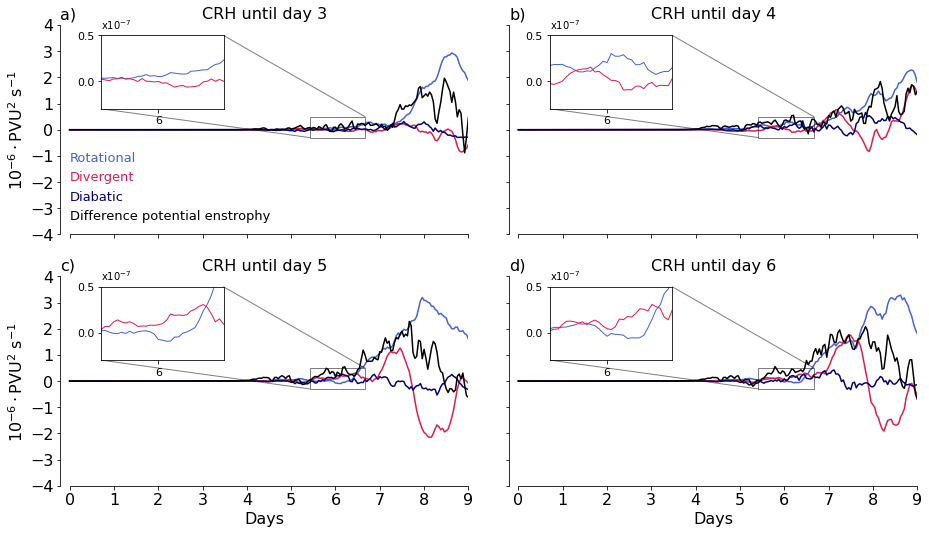

In [9]:
# plot 

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17, 8))

xaxis = np.arange(0,217,1)

i = 0

for ax in axes.flat:
    
    
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelsize=16)
    
    ax.spines['bottom'].set_bounds(0,216)
    ax.set_xticks(np.arange(0,217,24))
    ax.set_xticklabels(["0","1", "2", "3", "4", "5","6","7","8","9"])
    ax.set_xlim([-5, 216])
    
    ax.spines['left'].set_bounds(-4,4)
    ax.set_yticks(np.arange(-4,5,1))
    ax.set_ylim([-4,4])
    
    if i == 0:
        
        im = ax.plot(pver_02_05['ddtrot']*(1e6**2)*1e6,'#4363d8',label="Rotational",linewidth=1.5)
        im = ax.plot(pver_02_05['ddtdiv']*(1e6**2)*1e6,'#e6194B',label="Divergent",linewidth=1.5)
        im = ax.plot(pver_02_05['ddtdia']*(1e6**2)*1e6,'#000075',label="Diabatic",linewidth=1.5)
        im = ax.plot(pver_02_05['ddtpv_ens_cd']*(1e6**2)*1e6,'#000000',label="Difference potential enstrophy",linewidth=1.5)
        
        ax.set_title('CRH until day 3',fontsize=16) 
        ax.legend(prop={'size': 11}, frameon=False)
        lg=colorlegend.color_legend(ax,loc=3,fsize=13)
        ax.set_ylabel('$10^{-6} \cdot $PVU$^2$ s$^{-1}$',fontsize=16)
        ax.text(0.0, 1.03, 'a)', transform=ax.transAxes, 
            size=16)
        
        # inset axes....
        axins = ax.inset_axes([0.1, 0.6, 0.3, 0.35])
        axins.plot(pver_02_05['ddtrot']*(1e6**2)*1e6,'#4363d8',linewidth=1)
        axins.plot(pver_02_05['ddtdiv']*(1e6**2)*1e6,'#e6194B',linewidth=1)
        
        # sub region of the original image
        x1, x2, y1, y2 = 130, 160, -0.3, 0.5
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.spines['bottom'].set_bounds(130,160)
        axins.set_xticks([144])
        axins.set_xticklabels(["6"])
        
        axins.tick_params(labelsize=11) 
        axins.ticklabel_format(axis='y',useOffset=False) 
        axins.set_title('x10$^{-7}$',fontsize=10,loc='left')
        ax.indicate_inset_zoom(axins, edgecolor="black")
        
        ax.set_xticklabels([])
        
    elif i == 1:
        
        im = ax.plot(pver_02_06['ddtrot']*(1e6**2)*1e6,'#4363d8',label="Rotational",linewidth=1.5)
        im = ax.plot(pver_02_06['ddtdiv']*(1e6**2)*1e6,'#e6194B',label="Divergent",linewidth=1.5)
        im = ax.plot(pver_02_06['ddtdia']*(1e6**2)*1e6,'#000075',label="Diabatic",linewidth=1.5)
        im = ax.plot(pver_02_06['ddtpv_ens_cd']*(1e6**2)*1e6,'#000000',label="Observed PV error",linewidth=1.5)
        
        ax.set_title('CRH until day 4',fontsize=16)
        ax.text(0.0, 1.03, 'b)', transform=ax.transAxes, 
            size=16)
        
        # inset axes....
        axins = ax.inset_axes([0.1, 0.6, 0.3, 0.35])
        axins.plot(pver_02_06['ddtrot']*(1e6**2)*1e6,'#4363d8',linewidth=1)
        axins.plot(pver_02_06['ddtdiv']*(1e6**2)*1e6,'#e6194B',linewidth=1)
        
        # sub region of the original image
        x1, x2, y1, y2 = 130, 160, -0.3, 0.5
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.spines['bottom'].set_bounds(130,160)
        axins.set_xticks([144])
        axins.set_xticklabels(["6"])
        
        axins.tick_params(labelsize=11) 
        axins.ticklabel_format(axis='y',useOffset=False) 
        axins.set_title('x10$^{-7}$',fontsize=10,loc='left')
        ax.indicate_inset_zoom(axins, edgecolor="black")
        
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    elif i == 2:
        
        im = ax.plot(pver_02_07['ddtrot']*(1e6**2)*1e6,'#4363d8',label="Rotational",linewidth=1.5)
        im = ax.plot(pver_02_07['ddtdiv']*(1e6**2)*1e6,'#e6194B',label="Divergent",linewidth=1.5)
        im = ax.plot(pver_02_07['ddtdia']*(1e6**2)*1e6,'#000075',label="Diabatic",linewidth=1.5)
        im = ax.plot(pver_02_07['ddtpv_ens_cd']*(1e6**2)*1e6,'#000000',label="Time derivative of difference potential enstrophy",linewidth=1.5)
        
        ax.set_title('CRH until day 5',fontsize=16) 
        ax.set_ylabel('$10^{-6} \cdot $PVU$^2$ s$^{-1}$',fontsize=16)
        ax.set_xlabel('Days',fontsize=16)
        ax.text(0.0, 1.03, 'c)', transform=ax.transAxes, 
            size=16)
        
        
        # inset axes....
        axins = ax.inset_axes([0.1, 0.6, 0.3, 0.35])
        axins.plot(pver_02_07['ddtrot']*(1e6**2)*1e6,'#4363d8',linewidth=1)
        axins.plot(pver_02_07['ddtdiv']*(1e6**2)*1e6,'#e6194B',linewidth=1)
        
        # sub region of the original image
        x1, x2, y1, y2 = 130, 160, -0.3, 0.5
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.spines['bottom'].set_bounds(130,160)
        axins.set_xticks([144])
        axins.set_xticklabels(["6"])
        
        axins.tick_params(labelsize=11) 
        #axins.yaxis.set_major_formatter(formatter)
        axins.ticklabel_format(axis='y',useOffset=False) 
        #axins.ticklabel_format(useOffset=True)
        axins.set_title('x10$^{-7}$',fontsize=10,loc='left')
        ax.indicate_inset_zoom(axins, edgecolor="black")
        
    elif i == 3:
        
        im = ax.plot(pver_02_08['ddtrot']*(1e6**2)*1e6,'#4363d8',label="Rotational",linewidth=1.5)
        im = ax.plot(pver_02_08['ddtdiv']*(1e6**2)*1e6,'#e6194B',label="Divergent",linewidth=1.5)
        im = ax.plot(pver_02_08['ddtdia']*(1e6**2)*1e6,'#000075',label="Diabatic",linewidth=1.5)
        im = ax.plot(pver_02_08['ddtpv_ens_cd']*(1e6**2)*1e6,'#000000',label="Observed PV error",linewidth=1.5)
        
        ax.set_title('CRH until day 6',fontsize=16) 
        ax.text(0.0, 1.03, 'd)', transform=ax.transAxes, 
            size=16)
        ax.set_xlabel('Days',fontsize=16)
        ax.set_yticklabels([])
        
        # inset axes....
        axins = ax.inset_axes([0.1, 0.6, 0.3, 0.35])
        axins.plot(pver_02_08['ddtrot']*(1e6**2)*1e6,'#4363d8',linewidth=1)
        axins.plot(pver_02_08['ddtdiv']*(1e6**2)*1e6,'#e6194B',linewidth=1)
        
        # sub region of the original image
        x1, x2, y1, y2 = 130, 160, -0.3, 0.5
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.spines['bottom'].set_bounds(130,160)
        axins.set_xticks([144])
        axins.set_xticklabels(["6"])
        
        axins.tick_params(labelsize=11) 
        axins.ticklabel_format(axis='y',useOffset=False) 
        axins.set_title('x10$^{-7}$',fontsize=10,loc='left')
        ax.indicate_inset_zoom(axins, edgecolor="black")

    i = i + 1     

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.1, hspace=0.2)   

plt.savefig('figure15.pdf', bbox_inches = 'tight')
plt.savefig('figure15.png', bbox_inches = 'tight',dpi=100)